# Objective
* 20201111: 
    * Given daily returns for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * Using xgboost
    * Date features are not used here

In [825]:
import chart_studio.plotly as py
import math
import matplotlib
import numpy as np
import pandas as pd
import pickle
import pylab
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as pyo
import scipy.stats as stats
import time

from collections import defaultdict
from datetime import date
from fastai.tabular import add_datepart
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

pyo.init_notebook_mode()

# py.sign_in('<your-user-id>', '<your-api-key>') # sign in to plotly if you haven't done so

#### Input params ##################
folder = "./data/"
filename = "VTI_20130102_20181231.csv"

# Predicting on day 1008, date 2017-01-03 00:00:00
# Predicting on day 1050, date 2017-03-06 00:00:00
# Predicting on day 1092, date 2017-05-04 00:00:00
# Predicting on day 1134, date 2017-07-05 00:00:00
# Predicting on day 1176, date 2017-09-01 00:00:00
# Predicting on day 1218, date 2017-11-01 00:00:00
# Predicting on day 1260, date 2018-01-03 00:00:00
# Predicting on day 1302, date 2018-03-06 00:00:00
# Predicting on day 1344, date 2018-05-04 00:00:00
# Predicting on day 1386, date 2018-07-05 00:00:00
# Predicting on day 1428, date 2018-09-04 00:00:00
# Predicting on day 1470, date 2018-11-01 00:00:00

pred_day = 1470                # Predict for this day, for the next H-1 days. Note indexing of days start from 0.

H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                 # Use 1 year of data as validation set
N = 10                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

# Plotly colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


In [826]:
tic1 = time.time()

# Common functions

In [827]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_wape(y_true, y_pred): 
    """
    Compute weighted absolute percentage error (WAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return sum(np.abs(y_true - y_pred)) / sum(y_true) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

In [828]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out



def add_lags(df, N, lag_cols):
    """
    Add lags up to N number of days to use as features
    The lag columns are labelled as 'adj_close_lag_1', 'adj_close_lag_2', ... etc.
    """
    # Use lags up to N number of days to use as features
    df_w_lags = df.copy()
    df_w_lags.loc[:, 'order_day'] = [x for x in list(range(len(df)))] # Add a column 'order_day' to indicate the order of the rows by date
    merging_keys = ['order_day'] # merging_keys
    shift_range = [x+1 for x in range(N)]
    for shift in shift_range:
        train_shift = df_w_lags[merging_keys + lag_cols].copy()
    
        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df_w_lags, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift
    
        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df_w_lags = pd.merge(df_w_lags, train_shift, on=merging_keys, how='left') #.fillna(0)
    del train_shift
    
    return df_w_lags



# def get_error_metrics_one_pred(df,
#                                train_size,
#                                target,
#                                N,
#                                H,
#                                seed=100,
#                                n_estimators=100,
#                                max_depth=3,
#                                learning_rate=0.1,
#                                min_child_weight=1,
#                                subsample=1,
#                                colsample_bytree=1,
#                                colsample_bylevel=1,
#                                gamma=0):
#     """
#     Given a series consisting of both train+test, do one prediction of forecast horizon H on the test set.
#     Inputs
#         df                 : train + test dataframe. len(df) = train_size + test_size
#         train_size         : size of train set
#         target             : e.g. 'daily_ret'
#         N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
#         H                  : forecast horizon
#         seed               : model seed
#         n_estimators       : number of boosted trees to fit
#         max_depth          : maximum tree depth for base learners
#         learning_rate      : boosting learning rate (xgb’s “eta”)
#         min_child_weight   : minimum sum of instance weight(hessian) needed in a child
#         subsample          : subsample ratio of the training instance
#         colsample_bytree   : subsample ratio of columns when constructing each tree
#         colsample_bylevel  : subsample ratio of columns for each split, in each level
#         gamma              : 

#     Outputs
#         rmse, mape, mae, predictions
#     """    
#     # Add lags up to N number of days to use as features
#     df = add_lags(df, N, [target])
    
#     # Get list of features
# #     features_ex_adj_close = [
# #         'year',
# #         'month',
# #         'week',
# #         'day',
# #         'dayofweek',
# #         'dayofyear',
# #         'is_month_end',
# #         'is_month_start',
# #         'is_quarter_end',
# #         'is_quarter_start',
# #         'is_year_end'
# #     ]
# #     features = features_ex_adj_close # features contain all features, including adj_close_lags

#     features = []
#     for n in range(N,0,-1):
#         features.append(target+"_lag_"+str(n))
    
#     # Split into train and test
#     train = df[:train_size].copy()
#     test = df[train_size:train_size+H].copy()
    
#     # Drop the NaNs in train
#     train.dropna(axis=0, how='any', inplace=True)
        
#     # Split into X and y
#     X_train = train[features]
#     y_train = train[target]
#     X_test = test[features]
#     y_test_adj_close = test['adj_close']
#     prev_val = float(train['adj_close'][-1:])
            
#     rmse, mape, mae, est, feature_importances = train_pred_eval_model(X_train,
#                                                                       y_train,
#                                                                       X_test,
#                                                                       y_test_adj_close,
#                                                                       prev_val,
#                                                                       N,
#                                                                       H,
#                                                                       seed=seed,
#                                                                       n_estimators=n_estimators,
#                                                                       max_depth=max_depth,
#                                                                       learning_rate=learning_rate,
#                                                                       min_child_weight=min_child_weight,
#                                                                       subsample=subsample,
#                                                                       colsample_bytree=colsample_bytree,
#                                                                       colsample_bylevel=colsample_bylevel,
#                                                                       gamma=gamma)
    
#     return rmse, mape, mae, est, feature_importances, features

## pred_xgboost

In [829]:
def pred_xgboost(model, N, H, prev_targets):
    """
    Do recursive forecasting using xgboost
    Inputs
        model              : the xgboost model
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_targets       : numpy array. If predicting daily_ret at time t, 
                             prev_targets will contain the N daily_ret values at t-1, t-2, ..., t-N
    Outputs
        Times series of predictions. Numpy array of shape (H,). This is unscaled.
    """
    forecast = prev_targets.copy()

    for n in range(H):
        
        # Create the features dataframe
#         X = X_test_ex_lags[n:n+1].copy()
        X = defaultdict(list)
        for n in range(N,0,-1):
            X['daily_ret_lag_'+str(n)] = [forecast[-n]]
        X = pd.DataFrame(X)
             
        # Do prediction
        est = model.predict(X)
        
        # Concatenate the prediction
        forecast = np.concatenate([forecast, est])
           
    return forecast[-H:]

## train_pred_eval_model

In [830]:
def train_pred_eval_model(X_train,
                          y_train,
#                           X_test_ex_lags,
                          y_test_adj_close,
                          prev_val,
                          prev_targets,
                          N,
                          H,
                          seed=100,
                          n_estimators=100,
                          max_depth=3,
                          learning_rate=0.1,
                          min_child_weight=1,
                          subsample=1,
                          colsample_bytree=1,
                          colsample_bylevel=1,
                          gamma=0):
    '''
    Train model, do prediction, and do evaluation
    Use XGBoost here.
    Inputs
        X_train            : features for training
        y_train            : target for training
        X_test_ex_lags     : features of the test set, excluding the daily_ret lags
        y_test_adj_close   : target for test. This is adjusted close, not daily returns
        prev_val           : if predict at time t, this is the adj_close value at t-1
        prev_targets       : numpy array. If predicting daily_ret at time t, 
                             prev_targets will contain the N daily_ret values at t-1, t-2, ..., t-N
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        mae                : mean absolute error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(objective ='reg:squarederror',
                         seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
        
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predicted labels and scale back to original range
    est = pred_xgboost(model, N, H, prev_targets)
    
    # Convert back to price
    est_adj_close = []
    for n in range(H):
        prev_val = (est[n]/100+1)*prev_val
        est_adj_close.append(prev_val)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_test_adj_close, est_adj_close)
    mape = get_mape(y_test_adj_close, est_adj_close)
    mae = get_mae(y_test_adj_close, est_adj_close)
    
    return rmse, mape, mae, est_adj_close, model.feature_importances_

## get_error_metrics

In [831]:
def get_error_metrics(df,
                      train_size,
                      target,
                      N,
                      H,
                      seed=100,
                      n_estimators=100,
                      max_depth=3,
                      learning_rate=0.1,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      gamma=0):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                 : train + val dataframe. len(df) = train_size + val_size
        train_size         : size of train set
        target             : e.g. 'daily_ret'
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        mean of rmse, mean of mape, mean of mae, dictionary of predictions
    """
    rmse_list = [] # root mean square error
    mape_list = [] # mean absolute percentage error
    mae_list = []  # mean absolute error
    preds_dict = {}
    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, [target])
    
    features = []
    for n in range(N,0,-1):
        features.append(target+"_lag_"+str(n))
    
    for i in range(train_size, len(df)-H+1, int(H/2)):
        # Split into train and test
        train = df[i-train_size:i].copy()
        test = df[i:i+H].copy()
    
        # Drop the NaNs in train
        train.dropna(axis=0, how='any', inplace=True)
    
        # Split into X and y
        X_train = train[features]
        y_train = train[target]
#         X_test_ex_lags = test[features_ex_lags]
        y_test_adj_close = test['adj_close']
        prev_val = float(train['adj_close'][-1:])
        prev_targets = train[-N:][target].to_numpy()
                
        rmse, mape, mae, est, feature_importances = train_pred_eval_model(X_train,
                                                                          y_train,
#                                                                           X_test_ex_lags,
                                                                          y_test_adj_close,
                                                                          prev_val,
                                                                          prev_targets,
                                                                          N,
                                                                          H,
                                                                          seed=seed,
                                                                          n_estimators=n_estimators,
                                                                          max_depth=max_depth,
                                                                          learning_rate=learning_rate,
                                                                          min_child_weight=min_child_weight,
                                                                          subsample=subsample,
                                                                          colsample_bytree=colsample_bytree,
                                                                          colsample_bylevel=colsample_bylevel,
                                                                          gamma=gamma)
#         print("N = " + str(N) + ", i = " + str(i) + ", rmse = " + str(rmse) + ", mape = " + str(mape) + ", mae = " + str(mae))
        
        rmse_list.append(rmse)
        mape_list.append(mape)
        mae_list.append(mae)
        preds_dict[i] = est
    
    return np.mean(rmse_list), np.mean(mape_list), np.mean(mae_list), preds_dict, feature_importances, features 

# Load data

In [832]:
df = pd.read_csv(folder+filename, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

date       open       high        low      close  adj_close   volume
0 2013-01-02  74.529999  75.150002  74.500000  75.139999  66.997757  5037200
1 2013-01-03  75.120003  75.370003  74.839996  75.029999  66.899689  2634600
2 2013-01-04  75.139999  75.519997  74.989998  75.410004  67.238510  2512900
3 2013-01-07  75.180000  75.279999  74.949997  75.209999  67.060173  2511200
4 2013-01-08  75.110001  75.180000  74.699997  75.010002  66.881859  1407900
5 2013-01-09  75.190002  75.410004  75.110001  75.239998  67.086937  1421900
6 2013-01-10  75.620003  75.769997  75.220001  75.760002  67.550591  1403700
7 2013-01-11  75.760002  75.800003  75.510002  75.769997  67.559486  1248500
8 2013-01-14  75.750000  75.800003  75.440002  75.690002  67.488159  2745100
9 2013-01-15  75.400002  75.889999  75.339996  75.830002  67.612984  1109100

In [833]:
# Create returns column
df['daily_ret'] = 100.0 * ((df['adj_close'] / df['adj_close'].shift(1)) - 1)
df.head()

date       open       high        low      close  adj_close   volume  \
0 2013-01-02  74.529999  75.150002  74.500000  75.139999  66.997757  5037200   
1 2013-01-03  75.120003  75.370003  74.839996  75.029999  66.899689  2634600   
2 2013-01-04  75.139999  75.519997  74.989998  75.410004  67.238510  2512900   
3 2013-01-07  75.180000  75.279999  74.949997  75.209999  67.060173  2511200   
4 2013-01-08  75.110001  75.180000  74.699997  75.010002  66.881859  1407900   

   daily_ret  
0        NaN  
1  -0.146375  
2   0.506461  
3  -0.265230  
4  -0.265901

In [834]:
# Generate Gaussian curve to fit the daily returns
mu = df['daily_ret'].mean()
std = df['daily_ret'].std()
x = np.arange(df['daily_ret'].min(), df['daily_ret'].max(), 0.001)
y = [1/math.sqrt(2*math.pi)/std*math.exp(-((i-mu)**2)/2/(std**2)) for i in x]
gauss_df = pd.DataFrame({'x':x, 'y':y})
print("meam = " + str(mu) + ", std dev = " + str(std))

meam = 0.04543338844842776, std dev = 0.8134088128601789


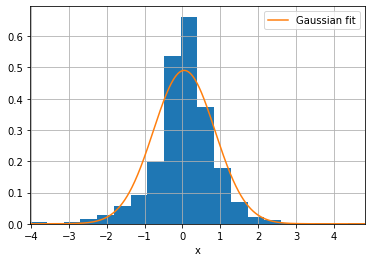

In [835]:
# Plot histogram of the daily returns
ax = df['daily_ret'].hist(bins=20, density=True)
gauss_df.plot(x='x', y='y', grid=True, ax=ax)
plt.legend(['Gaussian fit'])

In [836]:
fig = ff.create_distplot([np.array(df['daily_ret'][1:])], 
                         ['distplot'], 
                         bin_size=.1,
                         curve_type='normal', # override default 'kde'
                         )

# Add title
fig.update_layout(title_text='Distplot of daily returns with Normal Distribution')
fig.show()

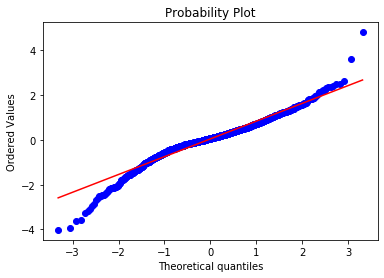

In [837]:
# Plot QQ plot
stats.probplot(df['daily_ret'][1:], dist="norm", plot=pylab)
pylab.show()

Looks mostly Gaussian, except for the extreme values

In [838]:
# Remove columns which you can't use as features
df.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

In [839]:
# Plot with plotly
data = [go.Scatter(
            x = df['date'],
            y = df['adj_close'],
            mode = 'lines')]

layout = dict(xaxis = dict(title = 'date'),
              yaxis = dict(title = 'USD'))

fig = dict(data=data, layout=layout)
pyo.iplot(fig, filename=filename)

# Feature Engineering

In [840]:
# #create features
# add_datepart(df, 'date', drop=False)
# df.drop('Elapsed', axis=1, inplace=True)  # don't need this
# df.head(50)

In [841]:
# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

In [842]:
# # Convert year to categorical feature, based on alphabetical order
# df.loc[:, 'year'] = LabelEncoder().fit_transform(df['year'])
# df.head()

# EDA

In [843]:
# Count number of nulls for each column
df.isnull().sum(axis=0)

date         0
adj_close    0
daily_ret    1
dtype: int64

In [844]:
# # Compute the average ret for each month
# avg_ret_mth = df.groupby("month").agg({'daily_ret': 'mean'}).reset_index()

# # Plot 
# data = [go.Scatter(
#             x = avg_ret_mth['month'],
#             y = avg_ret_mth['daily_ret'],
#             mode = 'markers',
#             marker=dict(
#                 color='LightSkyBlue',
#                 size=15,
#                 line=dict(
#                 color='MediumPurple',
#                 width=2
#                 ))
#         )]

# layout = dict(xaxis = dict(title = 'month'),
#               yaxis = dict(title = 'average daily return'))

# fig = dict(data=data, layout=layout)
# pyo.iplot(fig, filename='StockReturnsPrediction_v4_avg_ret_mth')

In [845]:
# # Compute the average daily return for each day of month
# avg_ret_day = df.groupby("day").agg({'daily_ret': 'mean'}).reset_index()

# # Plot 
# data = [go.Scatter(
#             x = avg_ret_day['day'],
#             y = avg_ret_day['daily_ret'],
#             mode = 'markers',
#             marker=dict(
#                 color='LightSkyBlue',
#                 size=15,
#                 line=dict(
#                 color='MediumPurple',
#                 width=2
#                 ))
#         )]

# layout = dict(xaxis = dict(title = 'day of month'),
#               yaxis = dict(title = 'average daily return'))

# fig = dict(data=data, layout=layout)
# pyo.iplot(fig, filename='StockPricePrediction_v4_avg_ret_dayofmonth')

In [846]:
# # Compute the average daily return for each day of week
# avg_ret_dayofweek = df.groupby("dayofweek").agg({'daily_ret': 'mean'}).reset_index()

# # Plot 
# data = [go.Scatter(
#             x = avg_ret_dayofweek['dayofweek'],
#             y = avg_ret_dayofweek['daily_ret'],
#             mode = 'markers',
#             marker=dict(
#                 color='LightSkyBlue',
#                 size=15,
#                 line=dict(
#                 color='MediumPurple',
#                 width=2
#                 ))
#         )]

# layout = dict(xaxis = dict(title = 'day of week'),
#               yaxis = dict(title = 'average daily return'))

# fig = dict(data=data, layout=layout)
# pyo.iplot(fig, filename='StockReturnsPrediction_v4_avg_ret_dayofweek')

In [847]:
# Create lags 
df_lags = add_lags(df, N, ['daily_ret'])
df_lags

date   adj_close  daily_ret  order_day  daily_ret_lag_1  \
0    2013-01-02   66.997757        NaN          0              NaN   
1    2013-01-03   66.899689  -0.146375          1              NaN   
2    2013-01-04   67.238510   0.506461          2        -0.146375   
3    2013-01-07   67.060173  -0.265230          3         0.506461   
4    2013-01-08   66.881859  -0.265901          4        -0.265230   
...         ...         ...        ...        ...              ...   
1504 2018-12-21  122.768997  -2.124119       1504        -1.614167   
1505 2018-12-24  119.699997  -2.499817       1505        -2.124119   
1506 2018-12-26  125.459999   4.812032       1506        -2.499817   
1507 2018-12-27  126.589996   0.900683       1507         4.812032   
1508 2018-12-28  126.430000  -0.126389       1508         0.900683   

      daily_ret_lag_2  daily_ret_lag_3  daily_ret_lag_4  daily_ret_lag_5  \
0                 NaN              NaN              NaN              NaN   
1                 NaN              NaN              NaN              NaN   
2                 NaN              NaN              NaN              NaN   
3           -0.146375              NaN              NaN              NaN   
4            0.506461        -0.146375              NaN              NaN   
...               ...              ...              ...              ...   
1504        -1.535630        -0.030701        -2.133407        -1.727460   
1505        -1.614167        -1.535630        -0.030701        -2.133407   
1506        -2.124119        -1.614167        -1.535630        -0.030701   
1507        -2.499817        -2.124119        -1.614167        -1.535630   
1508         4.812032        -2.499817        -2.124119        -1.614167   

      daily_ret_lag_6  daily_ret_lag_7  daily_ret_lag_8  daily_ret_lag_9  \
0                 NaN              NaN              NaN              NaN   
1                 NaN              NaN              NaN              NaN   
2                 NaN              NaN              NaN              NaN   
3                 NaN              NaN              NaN              NaN   
4                 NaN              NaN              NaN              NaN   
...               ...              ...              ...              ...   
1504        -0.243004         0.570274        -0.022207         0.111193   
1505        -1.727460        -0.243004         0.570274        -0.022207   
1506        -2.133407        -1.727460        -0.243004         0.570274   
1507        -0.030701        -2.133407        -1.727460        -0.243004   
1508        -1.535630        -0.030701        -2.133407        -1.727460   

      daily_ret_lag_10  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
1504         -2.359584  
1505          0.111193  
1506         -0.022207  
1507          0.570274  
1508         -0.243004  

[1509 rows x 14 columns]

In [848]:
# Compute correlation
features = [
        'daily_ret'
]
for n in range(N,0,-1):
    features.append("daily_ret_lag_"+str(n))
        
corr_matrix = df_lags[features].corr()
corr_matrix["daily_ret"].sort_values(ascending=False)

daily_ret           1.000000
daily_ret_lag_3     0.013938
daily_ret_lag_7     0.013390
daily_ret_lag_10    0.000328
daily_ret_lag_6    -0.006594
daily_ret_lag_1    -0.009077
daily_ret_lag_5    -0.023214
daily_ret_lag_2    -0.025624
daily_ret_lag_8    -0.037644
daily_ret_lag_9    -0.040409
daily_ret_lag_4    -0.047849
Name: daily_ret, dtype: float64

In [849]:
# Plot correlation for lag features only
features = ['daily_ret']
for n in range(1,N+1,1):
    features.append("daily_ret_lag_"+str(n))
        
corr_matrix = df_lags[features].corr()

z_list = []
for feat in features:
    z_list.append(corr_matrix.loc[:, feat][features])

fig = go.Figure(data=go.Heatmap(
                   z=z_list,
                   x=features,
                   y=features))
pyo.iplot(fig, filename='StockReturnsPrediction_v4_corr_matrix_lags')

In [850]:
# # Plot correlation for date features only
# features = [
#         'daily_ret',
#         'year',
#         'month',
#         'week',
#         'day',
#         'dayofweek',
#         'dayofyear',
#         'is_month_end',
#         'is_month_start',
#         'is_quarter_end',
#         'is_quarter_start',
#         'is_year_end',
#         'is_year_start'
# ]
        
# corr_matrix = df_lags[features].corr()

# z_list = []
# for feat in features:
#     z_list.append(corr_matrix.loc[:, feat][features])

# fig = go.Figure(data=go.Heatmap(
#                    z=z_list,
#                    x=features,
#                    y=features))
# pyo.iplot(fig, filename='StockReturnsPrediction_v4_corr_matrix_dates')

# Split into train, validation, test

In [851]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'], H))

Predicting on day 1470, date 2018-11-01 00:00:00, with forecast horizon H = 21


In [852]:
train = df[pred_day-train_val_size:pred_day-val_size].copy()
val = df[pred_day-val_size:pred_day].copy()
train_val = df[pred_day-train_val_size:pred_day].copy()
test = df[pred_day:pred_day+H].copy()
print("train.shape = " + str(train.shape))
print("val.shape = " + str(val.shape))
print("train_val.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))

train.shape = (756, 3)
val.shape = (252, 3)
train_val.shape = (1008, 3)
test.shape = (21, 3)


# Predict for a specific H (forecast horizon) and a specific date

In [853]:
# Get error metrics on validation set before hyperparameter tuning
rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning, preds_dict, feature_importances, features = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        'daily_ret',
                                                                        N,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators,
                                                                        max_depth=max_depth,
                                                                        learning_rate=learning_rate,
                                                                        min_child_weight=min_child_weight,
                                                                        subsample=subsample,
                                                                        colsample_bytree=colsample_bytree,
                                                                        colsample_bylevel=colsample_bylevel,
                                                                        gamma=gamma)
print("RMSE = %0.3f" % rmse_bef_tuning)
print("MAPE = %0.3f%%" % mape_bef_tuning)
print("MAE = %0.3f" % mae_bef_tuning)

RMSE = 3.060
MAPE = 1.882%
MAE = 2.593


In [854]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=[val['date'].min(), val['date'].max()])
fig.update_yaxes(range=[val['adj_close'].min(), val['adj_close'].max()])
# pyo.iplot(fig, filename='StockPricePrediction_v4_xgboost_val_' + str(pred_day))

In [855]:
# Do prediction on test set
test_rmse_bef_tuning, test_mape_bef_tuning, test_mae_bef_tuning, preds_dict, feature_importances, features = \
                                            get_error_metrics(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       'daily_ret',
                                                                       N,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators,
                                                                       max_depth=max_depth,
                                                                       learning_rate=learning_rate,
                                                                       min_child_weight=min_child_weight,
                                                                       subsample=subsample,
                                                                       colsample_bytree=colsample_bytree,
                                                                       colsample_bylevel=colsample_bylevel,
                                                                       gamma=gamma)

print("RMSE = %0.3f" % test_rmse_bef_tuning)
print("MAPE = %0.3f%%" % test_mape_bef_tuning)
print("MAE = %0.3f" % test_mae_bef_tuning)

RMSE = 2.547
MAPE = 1.395%
MAE = 1.919


In [856]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], 
                         y=preds_dict[list(preds_dict.keys())[0]],
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [857]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('daily_ret_lag_9', 0.0727259),
 ('daily_ret_lag_10', 0.07353741),
 ('daily_ret_lag_8', 0.07723563),
 ('daily_ret_lag_1', 0.087615706),
 ('daily_ret_lag_3', 0.08955666),
 ('daily_ret_lag_6', 0.09654475),
 ('daily_ret_lag_2', 0.10710909),
 ('daily_ret_lag_7', 0.110912375),
 ('daily_ret_lag_5', 0.13248715),
 ('daily_ret_lag_4', 0.15227538)]

# Predict for a specific H (forecast horizon) and a specific date, with hyperparam tuning

In [858]:
# We use a constant for N here
N_opt = N

## Tuning n_estimators (default=100) and max_depth (default=3)

In [859]:
param_label = 'n_estimators'
param_list = range(1, 61, 2)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _, _, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              'daily_ret',
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=param,
                                                              max_depth=param2,
                                                              learning_rate=learning_rate,
                                                              min_child_weight=min_child_weight,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 11.68


n_estimators  max_depth      rmse      mape       mae
0               1          2  7.848109  4.846767  6.720966
1               1          3  7.849775  4.847786  6.722561
2               1          4  7.836014  4.839115  6.709879
3               1          5  7.855827  4.852534  6.728779
4               1          6  7.850002  4.849290  6.724078
..            ...        ...       ...       ...       ...
235            59          5  2.988805  1.820998  2.511451
236            59          6  2.941302  1.800303  2.484802
237            59          7  2.949225  1.798592  2.483669
238            59          8  2.912970  1.784492  2.460896
239            59          9  3.051811  1.865471  2.575821

[240 rows x 5 columns]

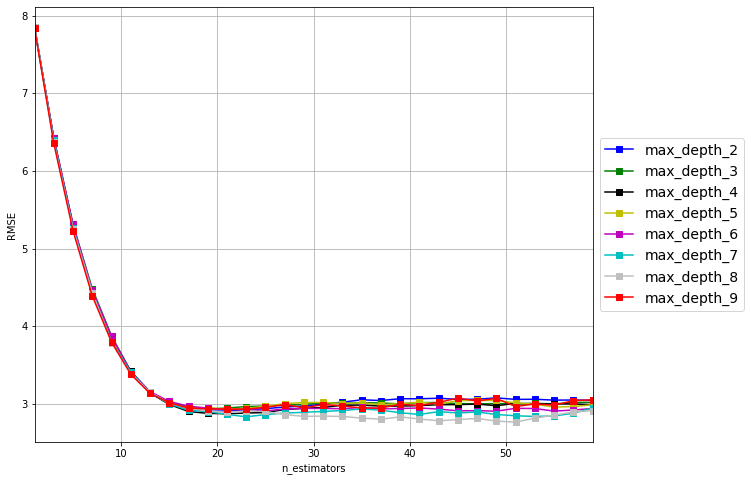

In [860]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [861]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 2.765
optimum params = 


(51, 8)

In [862]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 1.695%
optimum params = 


(49, 8)

## Tuning learning_rate(default=0.1) and min_child_weight(default=1)

In [863]:
param_label = 'learning_rate'
param_list = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _, _, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              'daily_ret',
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=param,
                                                              min_child_weight=param2,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 9.32


learning_rate  min_child_weight      rmse      mape       mae
0           0.0001                 5  8.664622  5.357899  7.433256
1           0.0001                 6  8.664839  5.358091  7.433525
2           0.0001                 7  8.664531  5.357869  7.433230
3           0.0001                 8  8.664362  5.357748  7.433079
4           0.0001                 9  8.662898  5.356745  7.431723
..             ...               ...       ...       ...       ...
123         0.3000                16  3.076961  1.887211  2.605166
124         0.3000                17  3.022121  1.847725  2.546352
125         0.3000                18  3.324295  2.004546  2.771224
126         0.3000                19  3.172201  1.939236  2.679944
127         0.3000                20  3.192762  1.936736  2.672698

[128 rows x 5 columns]

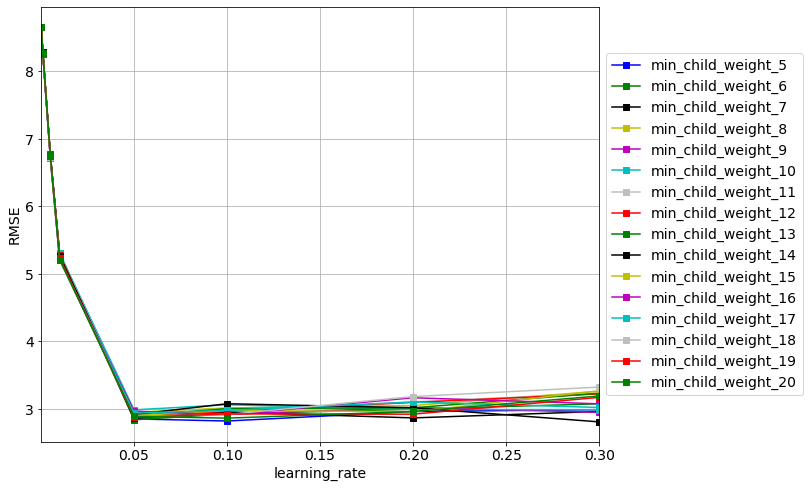

In [864]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 4])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [865]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 2.809
optimum params = 


(0.3, 14)

In [866]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 1.698%
optimum params = 


(0.3, 14)

## Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [867]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _, _, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              'daily_ret',
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=param,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 7.20


subsample  gamma      rmse      mape       mae
0          0.1    0.0  3.647607  2.218069  3.075125
1          0.1    0.1  3.732170  2.281847  3.162972
2          0.1    0.2  3.639457  2.210201  3.067234
3          0.1    0.3  3.308333  1.987444  2.760065
4          0.1    0.4  3.545338  2.157795  2.983050
..         ...    ...       ...       ...       ...
105        1.0    0.6  3.007522  1.853692  2.557971
106        1.0    0.7  2.904271  1.768142  2.434732
107        1.0    0.8  3.080725  1.892413  2.607873
108        1.0    0.9  3.266788  2.007249  2.774124
109        1.0    1.0  3.115843  1.919321  2.648963

[110 rows x 5 columns]

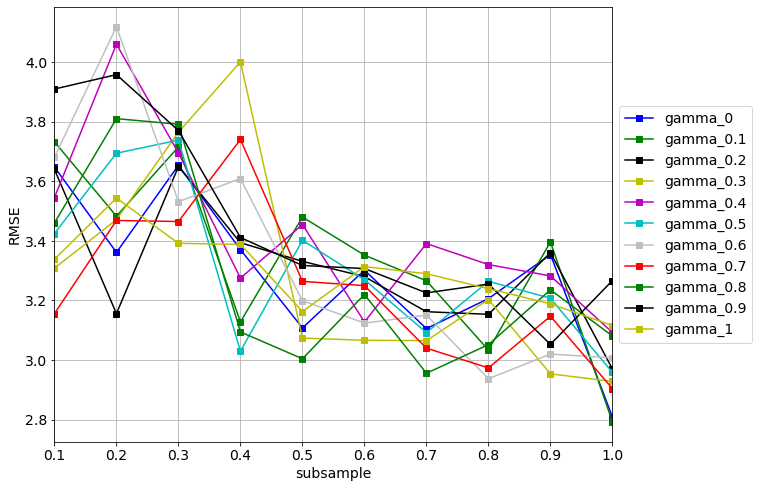

In [868]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [869]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 2.792
optimum params = 


(1.0, 0.1)

In [870]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 1.670%
optimum params = 


(1.0, 0.1)

## Tuning colsample_bytree(default=1) and colsample_bylevel(default=1)

In [871]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):    
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _, _, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              'daily_ret',
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=subsample_opt,
                                                              colsample_bytree=param,
                                                              colsample_bylevel=param2,
                                                              gamma=gamma_opt)

    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 2.61


colsample_bytree  colsample_bylevel      rmse      mape       mae
0                0.5                0.5  3.069953  1.884230  2.609072
1                0.5                0.6  3.049575  1.862994  2.569397
2                0.5                0.7  3.049575  1.862994  2.569397
3                0.5                0.8  3.248921  1.980693  2.744578
4                0.5                0.9  3.248921  1.980693  2.744578
5                0.5                1.0  2.883880  1.741506  2.402754
6                0.6                0.5  3.000983  1.830379  2.531168
7                0.6                0.6  3.000983  1.830379  2.531168
8                0.6                0.7  2.996697  1.786930  2.464876
9                0.6                0.8  2.996697  1.786930  2.464876
10               0.6                0.9  3.013035  1.857049  2.555402
11               0.6                1.0  3.012662  1.858136  2.562438
12               0.7                0.5  2.897840  1.772451  2.444077
13               0.7                0.6  3.177601  1.941378  2.685249
14               0.7                0.7  3.177601  1.941378  2.685249
15               0.7                0.8  3.235217  1.991474  2.756977
16               0.7                0.9  3.199448  1.971779  2.723962
17               0.7                1.0  3.274590  1.992735  2.753974
18               0.8                0.5  3.060491  1.858052  2.566275
19               0.8                0.6  3.060491  1.858052  2.566275
20               0.8                0.7  3.189716  1.959669  2.703136
21               0.8                0.8  3.014638  1.815178  2.502234
22               0.8                0.9  3.184110  1.965760  2.714160
23               0.8                1.0  2.877407  1.750718  2.412600
24               0.9                0.5  3.060140  1.887815  2.604088
25               0.9                0.6  2.974782  1.810553  2.493548
26               0.9                0.7  3.325869  2.055310  2.840700
27               0.9                0.8  3.155756  1.942881  2.679102
28               0.9                0.9  3.227540  1.991519  2.743434
29               0.9                1.0  3.151240  1.938699  2.678152
30               1.0                0.5  3.142553  1.942065  2.676339
31               1.0                0.6  3.021974  1.870432  2.576643
32               1.0                0.7  3.187812  1.963078  2.705891
33               1.0                0.8  3.080581  1.882710  2.602880
34               1.0                0.9  3.246773  1.980226  2.733075
35               1.0                1.0  2.792201  1.670259  2.302823

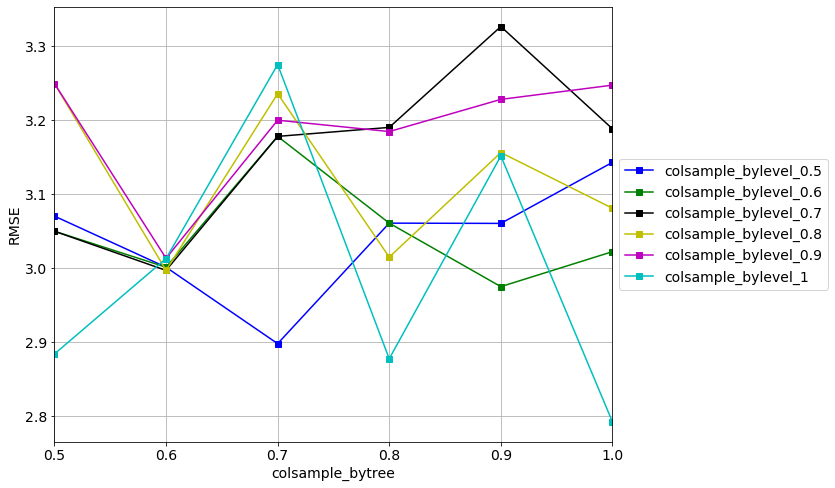

In [872]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [873]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 2.792
optimum params = 


(1.0, 1.0)

In [874]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 1.670%
optimum params = 


(1.0, 1.0)

## Final model

In [875]:
# Get error metrics on validation set after hyperparameter tuning
rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning, preds_dict, _, _ = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        'daily_ret',
                                                                        N_opt,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,
                                                                        learning_rate=learning_rate_opt,
                                                                        min_child_weight=min_child_weight_opt,
                                                                        subsample=subsample_opt,
                                                                        colsample_bytree=colsample_bytree_opt,
                                                                        colsample_bylevel=colsample_bylevel_opt,
                                                                        gamma=gamma_opt)
print("RMSE = %0.3f" % rmse_aft_tuning)
print("MAPE = %0.3f%%" % mape_aft_tuning)
print("MAE = %0.3f" % mae_aft_tuning)

RMSE = 2.792
MAPE = 1.670%
MAE = 2.303


In [876]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=[val['date'].min(), val['date'].max()])
fig.update_yaxes(range=[val['adj_close'].min(), val['adj_close'].max()])
# pyo.iplot(fig, filename='StockReturnsPrediction_v4_xgboost_val_aft_tune')

In [877]:
# Do prediction on test set
test_rmse_aft_tuning, test_mape_aft_tuning, test_mae_aft_tuning, preds_dict, feature_importances, features = \
                                            get_error_metrics(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       'daily_ret',
                                                                       N_opt,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators_opt,
                                                                       max_depth=max_depth_opt,
                                                                       learning_rate=learning_rate_opt,
                                                                       min_child_weight=min_child_weight_opt,
                                                                       subsample=subsample_opt,
                                                                       colsample_bytree=colsample_bytree_opt,
                                                                       colsample_bylevel=colsample_bylevel_opt,
                                                                       gamma=gamma_opt)


print("RMSE = %0.3f" % test_rmse_aft_tuning)
print("MAPE = %0.3f%%" % test_mape_aft_tuning)
print("MAE = %0.3f" % test_mae_aft_tuning)

RMSE = 3.379
MAPE = 2.050%
MAE = 2.867


In [878]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], 
                         y=preds_dict[list(preds_dict.keys())[0]],
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [879]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('daily_ret_lag_8', 0.080470115),
 ('daily_ret_lag_7', 0.087516494),
 ('daily_ret_lag_10', 0.08918287),
 ('daily_ret_lag_5', 0.090108275),
 ('daily_ret_lag_6', 0.09148333),
 ('daily_ret_lag_1', 0.09499031),
 ('daily_ret_lag_9', 0.1039478),
 ('daily_ret_lag_2', 0.11174432),
 ('daily_ret_lag_3', 0.12344009),
 ('daily_ret_lag_4', 0.12711634)]

In [880]:
# Plot the importance scores as a bar chart
fig = go.Figure(go.Bar(
            x=[item[1] for item in imp[-10:]],
            y=[item[0] for item in imp[-10:]],
            orientation='h'))
fig.show()
# pyo.iplot(fig, filename='StockReturnsPrediction_v4_xgboost_imp_scores')

## Tuned params

In [881]:
# Tuned params and before and after error metrics
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'val_rmse', 'val_mape', 'val_mae'],
     'before_tuning': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

param  before_tuning  after_tuning
0        n_estimators        100.000        51.000
1           max_depth          3.000         8.000
2       learning_rate          0.100         0.300
3    min_child_weight          1.000        14.000
4           subsample          1.000         1.000
5    colsample_bytree          1.000         1.000
6   colsample_bylevel          1.000         1.000
7               gamma          0.000         0.100
8            val_rmse          3.060         2.792
9            val_mape          1.882         1.670
10            val_mae          2.593         2.303

In [882]:
# Put tuned_params into pickle
pickle.dump(tuned_params, open("./out/v4_tuned_params_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

In [883]:
# pickle.load(open("./out/v6d_tuned_params_" + "2017-03-06" + ".pickle", "rb"))

In [884]:
toc1 = time.time()
print("Total minutes taken = {0:.2f}".format((toc1-tic1)/60.0))

Total minutes taken = 31.10


# Findings for a specific date

In [885]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'].strftime("%Y-%m-%d"), H))

Predicting on day 1470, date 2018-11-01, with forecast horizon H = 21


In [886]:
rmse_bef_tuning, rmse_aft_tuning

(3.0602158355258866, 2.792200790388297)

In [887]:
test_rmse_bef_tuning, test_rmse_aft_tuning

(2.546837223505071, 3.3785687299470415)

In [888]:
# Put results into pickle
pickle.dump(rmse_bef_tuning, open("./out/v4_val_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(rmse_aft_tuning, open("./out/v4_val_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_bef_tuning, open("./out/v4_test_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_bef_tuning, open("./out/v4_test_mape_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_bef_tuning, open("./out/v4_test_mae_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_aft_tuning, open("./out/v4_test_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_aft_tuning, open("./out/v4_test_mape_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_aft_tuning, open("./out/v4_test_mae_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(preds_dict[list(preds_dict.keys())[0]], open("./out/v4_test_est_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

## Findings across all dates

In [889]:
# Consolidate results
# H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
# train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
# val_size = 252                 # Use 1 year of data as validation set
# N = 10                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
results = defaultdict(list)
ests = {} # the predictions
date_list = ['2017-01-03',
             '2017-03-06',
             '2017-05-04',
             '2017-07-05',
             '2017-09-01',
             '2017-11-01',
             '2018-01-03',
             '2018-03-06',
             '2018-05-04',
             '2018-07-05',
             '2018-09-04',
             '2018-11-01'
            ]
for date in date_list:
    results['date'].append(date)
    results['val_rmse_bef_tuning'].append(pickle.load(open( "./out/v4_val_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['val_rmse_aft_tuning'].append(pickle.load(open( "./out/v4_val_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_bef_tuning'].append(pickle.load(open( "./out/v4_test_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_aft_tuning'].append(pickle.load(open( "./out/v4_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mape_bef_tuning'].append(pickle.load(open( "./out/v4_test_mape_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mape_aft_tuning'].append(pickle.load(open( "./out/v4_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mae_bef_tuning'].append(pickle.load(open( "./out/v4_test_mae_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mae_aft_tuning'].append(pickle.load(open( "./out/v4_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    ests[date] = pickle.load(open( "./out/v4_test_est_aft_tuning_" + date + ".pickle", "rb"))
    
results = pd.DataFrame(results)
results

date  val_rmse_bef_tuning  val_rmse_aft_tuning  \
0   2017-01-03             2.279900             1.972012   
1   2017-03-06             2.233328             1.756577   
2   2017-05-04             2.179883             1.685593   
3   2017-07-05             1.821588             1.301027   
4   2017-09-01             1.644756             1.294143   
5   2017-11-01             2.038213             1.263565   
6   2018-01-03             1.807392             1.247673   
7   2018-03-06             1.992140             1.783617   
8   2018-05-04             2.248226             1.990006   
9   2018-07-05             2.489996             2.108790   
10  2018-09-04             2.750060             2.280115   
11  2018-11-01             3.060216             2.792201   

    test_rmse_bef_tuning  test_rmse_aft_tuning  test_mape_bef_tuning  \
0               2.580461              1.489700              2.140027   
1               1.118026              1.843397              0.775299   
2               1.802299              0.796132              1.119666   
3               1.832964              0.957520              1.319089   
4               1.789958              1.280005              1.237969   
5               1.318345              0.890852              0.646286   
6               5.070941              3.992035              3.282324   
7               3.897255              4.151276              2.248790   
8               3.892227              3.425546              2.723095   
9               3.969469              3.528429              2.660452   
10              0.850190              2.198824              0.460729   
11              2.546837              3.378569              1.394502   

    test_mape_aft_tuning  test_mae_bef_tuning  test_mae_aft_tuning  
0               1.226251             2.420240             1.387073  
1               1.431662             0.905951             1.674262  
2               0.443086             1.342964             0.526748  
3               0.694376             1.624661             0.853622  
4               0.916554             1.553694             1.148995  
5               0.545450             0.849045             0.709208  
6               2.590635             4.640437             3.661840  
7               2.505369             3.006960             3.361253  
8               2.394043             3.767755             3.311657  
9               2.392096             3.817925             3.431328  
10              1.381700             0.682104             2.050695  
11              2.049907             1.919374             2.867219

In [890]:
# Generate a condensed dataframe of the above
results_short = defaultdict(list)
hyperparam_list = ['n_estimators', 
                   'max_depth', 
                   'learning_rate', 
                   'min_child_weight',
#                    'subsample',
#                    'colsample_bytree',
#                    'colsample_bylevel',
#                    'gamma'
                  ]

for date in date_list:
    results_short['date'].append(date)
    results_short['RMSE'].append(pickle.load(open( "./out/v4_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results_short['MAPE(%)'].append(pickle.load(open( "./out/v4_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results_short['MAE'].append(pickle.load(open( "./out/v4_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    
    tuned_params = pickle.load(open("./out/v4_tuned_params_" + date + ".pickle", "rb"))
    for hyperparam in hyperparam_list:
        results_short[hyperparam].append(tuned_params[tuned_params['param']==hyperparam]['after_tuning'].values[0])

    
results_short = pd.DataFrame(results_short)
results_short

date      RMSE   MAPE(%)       MAE  n_estimators  max_depth  \
0   2017-01-03  1.489700  1.226251  1.387073          19.0        7.0   
1   2017-03-06  1.843397  1.431662  1.674262          19.0        7.0   
2   2017-05-04  0.796132  0.443086  0.526748          23.0        2.0   
3   2017-07-05  0.957520  0.694376  0.853622          21.0        6.0   
4   2017-09-01  1.280005  0.916554  1.148995          31.0        2.0   
5   2017-11-01  0.890852  0.545450  0.709208          17.0        6.0   
6   2018-01-03  3.992035  2.590635  3.661840          17.0        9.0   
7   2018-03-06  4.151276  2.505369  3.361253          19.0        9.0   
8   2018-05-04  3.425546  2.394043  3.311657          21.0        4.0   
9   2018-07-05  3.528429  2.392096  3.431328          19.0        8.0   
10  2018-09-04  2.198824  1.381700  2.050695          15.0        7.0   
11  2018-11-01  3.378569  2.049907  2.867219          51.0        8.0   

    learning_rate  min_child_weight  
0             0.1               6.0  
1             0.1              10.0  
2             0.1              20.0  
3             0.1              10.0  
4             0.1              11.0  
5             0.1              16.0  
6             0.1               7.0  
7             0.1              11.0  
8             0.1               5.0  
9             0.1              18.0  
10            0.1               5.0  
11            0.3              14.0

In [891]:
results.mean()

val_rmse_bef_tuning     2.212142
val_rmse_aft_tuning     1.789610
test_rmse_bef_tuning    2.555748
test_rmse_aft_tuning    2.327690
test_mape_bef_tuning    1.667352
test_mape_aft_tuning    1.547594
test_mae_bef_tuning     2.210926
test_mae_aft_tuning     2.081992
dtype: float64

In [892]:
# Plot all predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'],
                         mode='lines',
                         name='adj_close',
                         line=dict(color='blue')))

# Plot the predictions
n = 0
for key in ests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['date'], 
                             y=ests[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=['2017-01-03', '2018-12-28'])
fig.update_yaxes(range=[110, 150])
# pyo.iplot(fig, filename='StockPricePrediction_v4_xgboost_predictions')

In [893]:
# Plot scatter plot of actual values vs. predictions
fig = go.Figure()

n = 0
for key in ests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['adj_close'], 
                             y=ests[key],
                             mode='markers',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.add_trace(go.Scatter(x=list(range(110, 155, 1)),
                         y=list(range(110, 155, 1)),
                         mode='lines',
                         name='actual values',
                         line=dict(color='blue')))

fig.update_layout(yaxis=dict(title='forecasts'),
                  xaxis=dict(title='adj_close'))
# pyo.iplot(fig, filename='StockPricePrediction_v4_xgboost_actuals_vs_predictions')

In [895]:
# Compare results with benchmark
all_results = pd.DataFrame({'Method': ['Last value',  'XGBoost w/o date features', 'XGBoost w date features'],
                            'RMSE': [2.53, 2.33, 2.37],
                            'MAPE(%)': [1.69, 1.55, 1.61],
                            'MAE': [2.26, 2.08, 2.11]})
all_results

Method  RMSE  MAPE(%)   MAE
0                 Last value  2.53     1.69  2.26
1  XGBoost w/o date features  2.33     1.55  2.08
2    XGBoost w date features  2.37     1.61  2.11